# N-Layer Neural Network in PyTorch

**|| Jonty Sinai ||** 08-04-2019

In this notebook I explore extending the multilayer perceptron to a standard fully connected network using PyTorch. Again I'll test the network on two classic and low compute datasets, namely MNIST and CIFAR-10

In [1]:
%matplotlib inline

import os
import random

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms

import matplotlib.pyplot as plt


HOME = os.environ['AI_HOME']
ROOT = os.path.join(HOME, 'artificial_neural_networks')
DATA = os.path.join(ROOT, 'data')
MNIST = os.path.join(DATA, 'mnist')
CIFAR10 = os.path.join(DATA, 'cifar10')

random.seed(1901)
np.random.seed(1901)
torch.manual_seed(1901)

## Multiple Hidden Layers

Early implementations of the MLP consisted of only one hidden layer, mainly due to computational constraints. Major breakthroughts in the predictive power of neural networks came when the number of layers was increased. Fundamentally the depth of a neural network is constrained by vanishing/exploding gradients. However modern techniques such as batch normalisation, Adam optimisation, dropout and others (this is continually evolving) make training higher depth neural networks possible. 

A basic schema for a fully connected neural network with multiple hidden layers is:

<br/>
<img src="./assets/dense_net.png" width="560">
<br/>

source: [M. Nielson, Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/chap6.html)

To specify such a network we need:

* The number of dense layers.
* The dimensionality of each hidden layer (equivalently the number of hidden units/features in each layer).
* The nonlinear activation functions of each layer.

> Note that once again since we're using PyTorch, there is no need to explicitly specify the softmax activation in the final output layer when using the `CrossEntropyLoss` loss function.

We will use PyTorch's `nn.ModuleList` and the `depth` argument to define the number of layers dynamically in the constructor. We'll pass a **list** specifying the number of "hidden units" in each layer (including the input and output layers) called `layer_dimensions`. For example in a 3-layer neural network with 10 input features, 8 hidden units and 2 classes we would pass:

    layer_dimensions = [10, 8, 2]

In [2]:
class DenseNet(nn.Module):
    
    def __init__(self, depth, layer_dims):
        super().__init__()
        assert len(layer_dims) - 1 == depth
        # ModuleList allows us to create differentiable layers in a Python list
        self.hidden_layers = nn.ModuleList(
                                [nn.Linear(layer_dims[i], layer_dims[i+1])
                                 for i in range(depth)])
        
    def forward(self, x):
        # ModuleList is an iterable
        for hidden in self.hidden_layers[:-1]:
            x = F.relu(hidden(x))
        # output layer
        return self.hidden_layers[-1](x)
        

## Test Implementation

In [3]:
architecture = [10, 8, 8, 6, 3]  # 10 input features, three hidden layers with 8, 8, 6 hidden units and 3 classes
dense_net = DenseNet(4, architecture)
print(dense_net)

DenseNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=3, bias=True)
  )
)


In [4]:
x = torch.randn(5, 10)

y = dense_net(x)
print(y)

tensor([[-0.2726,  0.0338, -0.1713],
        [-0.3023,  0.1014, -0.1529],
        [-0.3605,  0.1134, -0.1804],
        [-0.2955,  0.0065, -0.1824],
        [-0.2688,  0.0265, -0.1765]], grad_fn=<AddmmBackward>)


## Train and Evaluate Functions

We will use the exact same train and evaluate functions from the MLP example, this time we will allow the loss function and optimiser to be arguments.

In [5]:
def train(model, training_data, input_size, optimiser, loss_function, num_epochs):
    
    for epoch in range(num_epochs):
        print(f"Epoch: {epoch + 1} " + "="*80 + ">")
        
        total_loss = 0.0
        for batch_idx, batch in enumerate(training_data):
            images, labels = batch
            
            # zero accumulated gradients
            optimiser.zero_grad()
            
            # unroll images
            input_ = images.view(-1, input_size)
            # forward pass
            output = model(input_)
            # backward pass
            loss = loss_function(output, labels)
            loss.backward()
            optimiser.step()
            
            total_loss += loss.item()
            # print progress
            
            if (batch_idx + 1) % 1000 == 0:    # print every 1000 mini-batches
                print("[%4d/6000] loss: %.3f" %
                      (batch_idx + 1, total_loss / 1000))
                total_loss = 0.0
                
    print("Finished Training " + "="*71 + ">")

In [42]:
def evaluate(model, test_data, input_size):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_data:
            images, truth = data
            input_ = images.view(-1, input_size)
            output = model(input_)
            _, predicted = torch.max(output.data, 1)
            total += truth.size(0)
            correct += (predicted == truth).sum().item()

    print('Test accuracy on %d test images: %.4f %%' % (total, 100 * correct / total))

## MNIST

Define dataloaders for MNIST as seen in [mlp.ipynb](mlp.ipynb).

In [7]:
mnist_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.1307,), (0.3081,))]  # note that we normalise by rank-1 tensors
                )

In [8]:
# training set
mnist_trainset = torchvision.datasets.MNIST(root=MNIST, train=True, download=True, transform=mnist_transforms)
mnist_trainloader = torch.utils.data.DataLoader(mnist_trainset, batch_size=10, shuffle=True, num_workers=2)

In [9]:
# test set
mnist_testset = torchvision.datasets.MNIST(root=MNIST, train=False, download=True, transform=mnist_transforms)
mnist_testloader = torch.utils.data.DataLoader(mnist_testset, batch_size=10, shuffle=False, num_workers=2)

In [10]:
mnist_classes = tuple(f"{n}" for n in range(10))
print(mnist_classes)

('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')


Specify the architecture for MNIST. We'll only use four layers so that training doesn't take too long.

In [11]:
mnist_arch = [784, 512, 256, 10]
mnist_net = DenseNet(3, mnist_arch)

print(mnist_net)

DenseNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=10, bias=True)
  )
)


Now train

In [12]:
cross_entropy_mnist = nn.CrossEntropyLoss()
sgd_mnist = optim.SGD(mnist_net.parameters(), lr=0.001, momentum=0.9)

In [13]:
train(mnist_net, mnist_trainloader, 784, sgd_mnist, cross_entropy_mnist, num_epochs=3)

Epoch: 1 ================================================================================>
[1000/6000] loss: 0.788
[2000/6000] loss: 0.317
[3000/6000] loss: 0.273
[4000/6000] loss: 0.217
[5000/6000] loss: 0.195
[6000/6000] loss: 0.179
Epoch: 2 ================================================================================>
[1000/6000] loss: 0.144
[2000/6000] loss: 0.131
[3000/6000] loss: 0.121
[4000/6000] loss: 0.115
[5000/6000] loss: 0.110
[6000/6000] loss: 0.109
Epoch: 3 ================================================================================>
[1000/6000] loss: 0.091
[2000/6000] loss: 0.081
[3000/6000] loss: 0.081
[4000/6000] loss: 0.071
[5000/6000] loss: 0.074
[6000/6000] loss: 0.081
Finished Training =======================================================================>


With the simple MLP the loss was 0.083 after three epochs. Let's see how this translates visually:

In [14]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

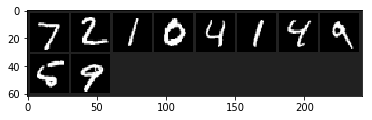

Groundtruth:      7     2     1     0     4     1     4     9     5     9


In [15]:
data_iter = iter(mnist_testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join('%5s' % mnist_classes[labels[j]] for j in range(10)))

In [16]:
input_ = images.view(-1, 784)
output = mnist_net(input_)
_, predicted = torch.max(output, 1)

print('Predicted: ', ' '.join('%5s' % mnist_classes[predicted[j]] for j in range(10)))

Predicted:      7     2     1     0     4     1     4     9     5     9


Compared to the simple MLP the 4-layer fully connected network gets all of the examples in the first batch right, including that wonky 5!

Now let's evaluate:

In [43]:
evaluate(mnist_net, mnist_testloader, 784)

Test accuracy on 10000 test images: 97.3600 %


## CIFAR-10

Now define dataloaders for CIFAR-10 as seen in [mlp.ipynb](mlp.ipynb).

In [18]:
cifar10_transforms = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]  # note that we normalise by rank-1 tensors
                )

In [19]:
cifar10_trainset = torchvision.datasets.CIFAR10(root=CIFAR10, train=True, download=True, transform=cifar10_transforms)
cifar10_trainloader = torch.utils.data.DataLoader(cifar10_trainset, batch_size=10, shuffle=True, num_workers=2)

Files already downloaded and verified


In [20]:
cifar10_testset = torchvision.datasets.CIFAR10(root=CIFAR10, train=False, download=True, transform=cifar10_transforms)
cifar10_testloader = torch.utils.data.DataLoader(cifar10_testset, batch_size=10, shuffle=False, num_workers=2)

Files already downloaded and verified


In [21]:
cifar10_classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Specify the architecture for MNIST. We'll only use four layers so that training doesn't take too long.

In [33]:
cifar10_arch = [3072, 512, 512, 10]
cifar10_net = DenseNet(3, cifar10_arch)

print(cifar10_net)

DenseNet(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=3072, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)


Now train

In [34]:
cross_entropy = nn.CrossEntropyLoss()
sgd_cifar10 = optim.SGD(cifar10_net.parameters(), lr=0.001, momentum=0.9)

In [35]:
train(cifar10_net, cifar10_trainloader, 3072, sgd_cifar10, cross_entropy, num_epochs=3)

Epoch: 1 ================================================================================>
[1000/6000] loss: 2.005
[2000/6000] loss: 1.748
[3000/6000] loss: 1.655
[4000/6000] loss: 1.605
[5000/6000] loss: 1.541
Epoch: 2 ================================================================================>
[1000/6000] loss: 1.480
[2000/6000] loss: 1.475
[3000/6000] loss: 1.459
[4000/6000] loss: 1.422
[5000/6000] loss: 1.427
Epoch: 3 ================================================================================>
[1000/6000] loss: 1.342
[2000/6000] loss: 1.347
[3000/6000] loss: 1.346
[4000/6000] loss: 1.310
[5000/6000] loss: 1.318
Finished Training =======================================================================>


In [36]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

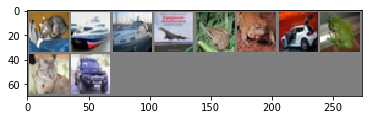

Groundtruth:    cat  ship  ship plane  frog  frog   car  frog   cat   car


In [37]:
data_iter = iter(cifar10_testloader)
images, labels = data_iter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('Groundtruth: ', ' '.join('%5s' % cifar10_classes[labels[j]] for j in range(10)))

In [38]:
input_ = images.view(-1, 3072)
outputs = cifar10_net(input_)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % cifar10_classes[predicted[j]] for j in range(10)))

Predicted:   ship truck  ship  ship  deer  frog   cat  frog   dog   car


Now let's evaluate:

In [44]:
evaluate(cifar10_net, cifar10_testloader, 3072)

Test accuracy on 10000 test images: 52.4600 %


Once again we are able to beat the simple MLP on CIFAR-10 by a few percentage points and once again it we can improve on this using more powerful models.